255


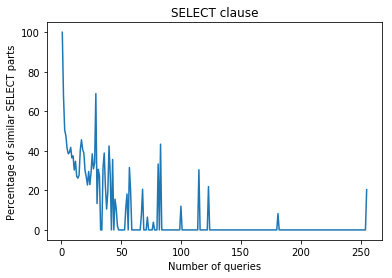

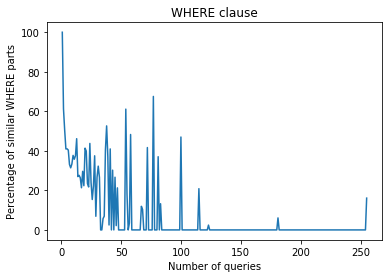

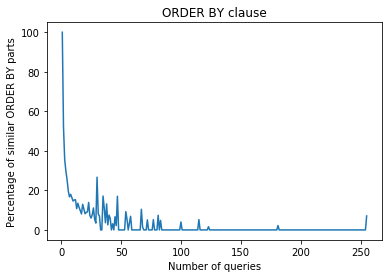

In [11]:
import matplotlib.pyplot as plt
import collections
import re
import numpy as np
import sqlparse
from sqlparse.sql import IdentifierList, Identifier, Where, Token, Function
from sqlparse.tokens import Keyword, DML, Whitespace, Newline, Name, Comparison, Operator
from collections import OrderedDict


table_dict = {}


def extract_from_part(parsed):
    '''
    @param parsed: a parsed SQL query
    @return: list of tokens in the FORM clause
    '''
    from_seen = False
    for item in parsed.tokens:
        if from_seen:
            if item.ttype == Newline or item.ttype == Whitespace:
                continue
            else:
                if isinstance(item,IdentifierList):
                    res = []
                    for each in item:
                        if isinstance(each,Identifier):
                            res.append(each.get_real_name().lstrip().rstrip())
                    return ",".join(res)
                elif isinstance(item, Identifier):
                    return item.get_real_name()
        elif item.ttype is Keyword and item.value.upper() == 'FROM':
            from_seen = True
            
def extract_select_part(parsed):
    '''
    @param parsed: a parsed SQL query
    @return: a string of SELECT clause
    '''
    select_seen = False
    for item in parsed.tokens:
        if select_seen:
            if item.ttype == Newline or item.ttype == Whitespace:
                continue
            else:
                if isinstance(item,IdentifierList):
                    res = []
                    for each in item:
                        if isinstance(each,Identifier):
                            res.append(each.value.lstrip().rstrip())
                        elif isinstance(each,Function):
                            res.append(each.value)
                    return ",".join(res)
                elif isinstance(item, Identifier):
                    return item.get_real_name()
        elif item.ttype is DML and item.value.upper() == 'SELECT':
            select_seen = True
    
def extract_where_part(parsed):
    '''
    @param parsed: a parsed SQL query
    @return: string of the WHERE clause
    '''
    res = []
    for item in parsed.tokens:
        if isinstance(item, Where):
            for token in item:
                if token.ttype == Newline or token.ttype == Whitespace:
                    continue
                else:
                    res.append(token.value)
    return " ".join(res).lstrip().rstrip()



def extract_orderby_part(parsed):
    '''
    @param parsed: a parsed SQL query
    @return: a string of ORDER BY clause
    '''
    order_seen = False
    for item in parsed.tokens:
        if order_seen:
            if item.ttype == Whitespace or item.ttype == Newline or (item.ttype == Keyword and item.value.upper()=="BY"):
                continue
            else:
                return item.value.lstrip().rstrip()
        elif item.ttype == Keyword and item.value.upper() == "ORDER":
            order_seen = True
        
    
        
def get_queries(file_name):
    '''
    @param file_name: name of the file to be processed
    @return: list of string of queries
    '''

    f = open(file_name,"r")

    queries = []
    current_query =""
    
    #removing any extra white spaces from the queries and put them in a list "queries" 
    for line in f:
        line = line.lstrip()
        # ignore comments
        if line[0:2] == "--":
            continue
        if line != "" and line[0] != "_":
            current_query += line
        if line!= "" and line[0] == "_":
            if current_query != "":
                queries.append(current_query)
                current_query =""
    
    f.close()
    return queries


def populate_dictionary(file_name, table_dict):
    '''
    @param file_name: file name containing queries
    @param table_dict: dictionary to store queries with the key being FROM clause
    '''
    queries = get_queries(file_name)
    
    for query in queries:
        parsed = sqlparse.parse(query)[0]
        from_part_key = extract_from_part(parsed)
        if table_dict.get(from_part_key) is None:
            table_dict[from_part_key] = [query]
        else:
            table_dict[from_part_key].append(query)

            
            
populate_dictionary("queries.txt", table_dict)

max_count = 0

#array to store number of queries with length i+1, where i is an index
count_array = [0]*255

#arrays to store the factors of distinct queries in a table, i.e. # of distinct queries in a table/ total # of queries in a table
select_factor_array = [0]*255
where_factor_array = [0]*255
orderby_factor_array = [0]*255


for key, queries in table_dict.items():
    #dictionaries to store number of distinct parts of each clause in a table
    tempdict_select = {}
    tempdict_where = {}
    tempdict_orderby = {}
    
    #number of queries in a table
    count = 0
    for query in queries:
        parsed = sqlparse.parse(query)[0]
        select_part = extract_select_part(parsed)
        where_part = extract_where_part(parsed)
        orderby_part = extract_orderby_part(parsed)
        
        
        val_select = tempdict_select.get(select_part, 0)
        val_where = tempdict_where.get(where_part, 0)
        val_orderby = tempdict_orderby.get(orderby_part, 0)

        
        tempdict_select[select_part] = val_select + 1
        tempdict_where[where_part] = val_where + 1
        tempdict_orderby[orderby_part] = val_orderby + 1
        
        count += 1
    max_count = max(count, max_count)
    
    count_array[count-1] += 1
    select_factor_array[count-1] += len(tempdict_select)/count
    where_factor_array[count-1] += len(tempdict_where)/count
    orderby_factor_array[count-1] += len(tempdict_orderby)/count
    
    
print(max_count)
   
for i in range(len(count_array)):
    if select_factor_array[i] != 0:
        select_factor_array[i] = select_factor_array[i]/count_array[i]*100
    if where_factor_array[i] != 0:
        where_factor_array[i] = where_factor_array[i]/count_array[i]*100
    if orderby_factor_array[i] != 0:
        orderby_factor_array[i] = orderby_factor_array[i]/count_array[i]*100
    



### PLOTS

plt.figure(1)
plt.subplot(111)
plt.plot(list(range(1,256)),select_factor_array)
plt.title("SELECT clause")
plt.ylabel("Percentage of similar SELECT parts")
plt.xlabel("Number of queries")
plt.show()

plt.figure(2)
plt.subplot(111)
plt.plot(list(range(1,256)),where_factor_array)
plt.title("WHERE clause")
plt.ylabel("Percentage of similar WHERE parts")
plt.xlabel("Number of queries")
plt.show()

plt.figure(3)
plt.subplot(111)
plt.plot(list(range(1,256)),orderby_factor_array)
plt.title("ORDER BY clause")
plt.ylabel("Percentage of similar ORDER BY parts")
plt.xlabel("Number of queries")
plt.show()


